In [1]:
!pip install pgmpy==0.1.24
!pip install pandas==2.0.3
!pip install networkx==3.3

## Listing 4.1 D-separation analysis of the DAG in Figure 4.15

Causal relationships impose conditional independence constraints on the joint probability distribution of the variables in the data generating process. [D-separation](https://networkx.org/documentation/stable/reference/algorithms/d_separation.html) is a graphical criterion used to determine whether a set of variables is independent of another set of variables, given a third set. The causal Markov assumption says that if our selected causal DAG is true, then variables that are d-separated in the graph will be conditionally independent. Let’s revisit the transportation model:

![transportation DAG](https://github.com/altdeep/causalML/blob/master/book/chapter%204/images/transportation_DAG.png?raw=1)

* Age (A): Recorded as young (young) for individuals up to and including 29 years, adult (adult) for individuals between 30 and 60 years old (inclusive), and old (old) for people 61 and over.
* Gender (S): The self-reported gender of an individual, recorded as male (M), female (F), or other (O).
* Education (E): The highest level of education or training completed by the individual, recorded either high school (high) or university degree (uni).
* Occupation (O): Employee (emp) or a self-employed (self) worker.
* Residence (R): The population size of the city the individual lives in, recorded as small (small) or big (big).
* Travel (T): The means of transport favored by the individual, recorded as car (car), train (train) or other (other)

Age (A) and Gender (S) determine Education (E). Education causes Occupation (O) and Residence (R). Occupation and Residence causes Transportation (T).

In [2]:
from networkx import is_d_separator     #A
from pgmpy.base import DAG    #B
dag = DAG([    #B
    ('I', 'U'),    #B
    ('I', 'M'),    #B
    ('M', 'U'),    #B
    ('J', 'V'),    #B
    ('J', 'M'),    #B
    ('M', 'V')    #B
])    #B
print(is_d_separator(dag, {"U"}, {"V"}, {"M"}))    #C
print(is_d_separator(dag, {"U"}, {"V"}, {"M", "I", "J"}))    #D
print(is_d_separator(dag, {"U"}, {"V"}, {"M", "I"}))    #E
print(is_d_separator(dag, {"U"}, {"V"}, {"M", "J"}))    #E
#A The graph library networkx implements the d-separation algorithm for networkx graph objects such as DiGraph (directed graph).
#B DAG is a base class for the BayesianNetwork class. The base class for DAG is networkx’s DiGraph. So d_separated will work on objects of the class DAG (and BayesianNetwork).
#C Builds the graph in Figure 4.11. Blocking on a collider M blocks the path U ← M → V but will d-connect the path U ← I → M ← J → V. So this will print False.
#D Blocking on M will block U ← M → V and open (d-connect) U ← I → M ← J → V, but we can block that path with I and J. So this evaluates to True.
#E But blocking on both I and J is overkill, the minimal d-separating sets are {“M”, “I”} and {“M”, “J”}.

False
True
True
True


## Listing 4.2 Enumerating d-separations in pgmpy

The method `get_independencies` will enumerate the d-separation statements that hold for this graph. Note that pgmpy attempts to remove redundant d-separations from this enumeration.

In [3]:
from pgmpy.base import DAG
dag = DAG([
    ('I', 'U'),
    ('I', 'M'),
    ('M', 'U'),
    ('J', 'V'),
    ('J', 'M'),
    ('M', 'V')
])
dag.get_independencies()    #A
#A Obtain all the minimal d-separations statements that are true in the DAG.

(J ⟂ I)
(J ⟂ U | M, I)
(J ⟂ U | V, M, I)
(I ⟂ J)
(I ⟂ V | J, M)
(I ⟂ V | J, M, U)
(V ⟂ I, U | J, M)
(V ⟂ U | M, I)
(V ⟂ U | J, M, I)
(V ⟂ I | J, M, U)
(U ⟂ V | J, M)
(U ⟂ J, V | M, I)
(U ⟂ V | J, M, I)
(U ⟂ J | V, M, I)

## Listing 4.3 Loading the transportation data

First, let's load the data.

In [4]:
import pandas as pd
survey_url = "https://raw.githubusercontent.com/altdeep/causalML/master/datasets/transportation_survey.csv"
fulldata = pd.read_csv(survey_url)

data = fulldata[0:30]    #A
print(data[0:5])

#A Subsetting the data to only 30 datapoints for explanation.

       A  S     E    O      R      T
0  adult  F  high  emp  small  train
1  young  M  high  emp    big    car
2  adult  M   uni  emp    big  other
3    old  F   uni  emp    big    car
4  young  F   uni  emp    big    car


## Listing 4.4 chi-squared test of conditional independence

The easiest way (but not the only way) to test for conditional independence is to run a classical frequentist statistical hypothesis test for independence. Below, I write a function that will run a Chi-square test for independence. The core element of the code is the function:

`chi_square(X=X, Y=Y, Z=Z, data=data, boolean=True, significance_level=significance)`

If the boolean argument is False, the test returns a tuple containing chi-squared test statistic, the p_value, and the degrees of freedom) used to calculate the test statistic and p-value. In this test, lower p-values are evidence against independence. So lower p-values are evidence against our model.

For each of the above d-separation statements, I run the test.

In [5]:
from pgmpy.estimators.CITests import chi_square    #A
significance = .05    #B
result = chi_square(    #C
    X="E", Y="T", Z=["O", "R"],    #C
    data=data,    #C
    boolean=False,    #C
    significance_level=significance    #C
)    #C
print(result)
#A Import the chi square test function.
#B Set the significance level to .05.
#C When the `boolean` argument is set to false, the test returns a tuple of three elements. The first two are the Chi-square statistic and the corresponding the p-value of 0.56. The last element is a Chi-square distribution parameter called degrees of freedom, which is needed to calculate the p-value.

(1.1611111111111112, 0.5595873983053805, 2)


## Listing 4.5 Chi-square test with Boolean outcome

I can jump directly to the result of the test by setting the chi_square function's boolean argument to True. The function will then return True if the p-value is greater than the significance value (favoring conditional independence) and False otherwise (favoring dependence).

To make life a bit easier, we can define a cut-off and evaluate how many tests meet (or fail to meet) the cut-off. Since this is a statistical hypothesis test, the most straightforward cut-off is a [significance level](https://en.wikipedia.org/wiki/Statistical_significance), against which we can directly compare the p-value. If the `boolean` argument in `chi_square` is true and we provide a significance level, then the test will return True if the p_value of the test is greater than  the significance_level (evidence in favor of independence), otherwise it will returns False. Below, we'll look of the proportion of tests that beat this significance level.

In [6]:
from pgmpy.estimators.CITests import chi_square    #A
significance = .05    #B
result = chi_square(    #C
    X="E", Y="T", Z=["O", "R"],    #C
    data=data,    #C
    boolean=True,    #C
    significance_level=significance    #C
)    #C
print(result)
#A Import the chi_square test function.
#B Set the significance level to .05.
#C When the `boolean` argument is set to True, the test returns a simple True or False outcome. It will return True if the p-value is greater than the significance value, which favors conditional independence. It returns False otherwise, favoring dependence.

True


## Listing 4.6 Run a chi-squared test for each d-separation statement

Now, let's iterate throw all the d-separation statements we can derive from the transportation graph, and test them one-by-one. The following script will print each d-separation statement along with the outcome of the corresponding conditional independence test.

In [7]:
from pprint import pprint

from pgmpy.base import DAG
from pgmpy.independencies import IndependenceAssertion

dag = DAG([
    ('A', 'E'),
    ('S', 'E'),
    ('E', 'O'),
    ('E', 'R'),
    ('O', 'T'),
    ('R', 'T')
])
dseps = dag.get_independencies()

def test_dsep(dsep):
    test_outputs = []
    for X in list(dsep.get_assertion()[0]):
        for Y in list(dsep.get_assertion()[1]):
            Z = list(dsep.get_assertion()[2])
            test_result = chi_square(
                X=X, Y=Y, Z=Z,
                data=data,
                boolean=True,
                significance_level=significance
            )
            assertion = IndependenceAssertion(X, Y, Z)
            test_outputs.append((assertion, test_result))
    return test_outputs

results = [test_dsep(dsep) for dsep in dseps.get_assertions()]
results = dict([item for sublist in results for item in sublist])
pprint(results)

{(S ⟂ R | E): True,
 (T ⟂ A | E, S, R, O): True,
 (E ⟂ T | S, R, A, O): True,
 (T ⟂ A | S, R, O): True,
 (O ⟂ A | E): True,
 (S ⟂ T | E): True,
 (S ⟂ O | E, T): True,
 (S ⟂ R | E, T): True,
 (S ⟂ R | E, O): True,
 (E ⟂ T | S, R, O): True,
 (E ⟂ T | R, O): True,
 (O ⟂ R | E): False,
 (S ⟂ O | E): True,
 (E ⟂ T | R, A, O): True,
 (S ⟂ T | E, O): True,
 (S ⟂ A): True,
 (S ⟂ T | E, R): True,
 (S ⟂ O | E, A): True,
 (S ⟂ O | E, R): True,
 (S ⟂ R | E, T, O): True,
 (S ⟂ T | R, O): True,
 (S ⟂ T | E, A): True,
 (S ⟂ T | E, R, A): True,
 (S ⟂ R | E, A): True,
 (O ⟂ R | E, S): False,
 (S ⟂ T | E, R, O): True,
 (O ⟂ A | E, R): True,
 (S ⟂ O | E, R, T): True,
 (O ⟂ A | E, S, T): True,
 (S ⟂ O | E, R, A): True,
 (O ⟂ R | E, A): False,
 (T ⟂ A | E, R): True,
 (S ⟂ T | E, A, O): True,
 (S ⟂ T | E, R, A, O): True,
 (S ⟂ T | R, A, O): True,
 (S ⟂ R | E, A, O): True,
 (O ⟂ A | E, S): True,
 (O ⟂ A | E, S, R): True,
 (O ⟂ A | E, T): True,
 (R ⟂ A | E): True,
 (T ⟂ A | E, S): True,
 (T ⟂ A | E, S, R): Tr

## Listing 4.7 Calculate the proportion of d-separations with passing tests

In [8]:
num_pass = sum(results.values())
num_dseps = len(dseps.independencies)
num_fail = num_dseps - num_pass
print(num_fail / num_dseps)

0.2875


The conclusion of a traditional conditional independence test depends on a significance threshold. If the p-value falls below this threshold you favor dependence and if it falls above, you favor conditional independence. The choice of threshold is a bit arbitrary; people tend to go with commonly selected values like .1 or .05 or .01.

The problem is that the p-value statistic varies with the size of the data. All else equal, as the size of the data increases, the p-value decreases. In other words, the larger the data, the more things start to look dependent. If you have a large dataset, it is more likely that p-values will fall below that arbitrary threshold and the data will look like it's refuting the conditional independence implied by your DAG, even when that conditional independence is true.

To illustrate, the above test of E ⟂ T | O, R had 30 data points and produced a p-value of 0.56. Below, I run the following bootstrap statistical analysis to show how the estimate of the p-value falls as the size of the data increases.

## Listing 4.8 Bootstrap analysis of sensitivity of test of E ⟂ T | O, R to sample size

First we'll create a function that given a size of the dataset, will produce a p-value. It will use a "[bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#:~:text=Bootstrapping%20is%20any%20test%20or%20metric%20that%20uses,confidence%20intervals%2C%20prediction%20error%2C%20etc.%29%20to%20sample%20estimates.)" approach to [sample with replacement](https://en.wikipedia.org/wiki/Sampling_(statistics)#Replacement_of_selected_units) from a subset of the data with the given data size, and run the chi-square indepedence test on this sample.

The second function , for a given data size, we'll calculate 1000 of these p-values, and calculate the mean, and a 90% confidence interval. We'll plot these for a sequence of data sizes.

In [16]:
from numpy import mean, quantile

def sample_p_val(data_size, data, alpha):    #A
    bootstrap_data = data.sample(n=data_size, replace=True)    #A
    result = chi_square(    #A
        X="E", Y="T", Z=["O", "R"],    #A
        data=bootstrap_data,    #A
        boolean=False,    #A
        significance_level = alpha    #A
    )    #A
    p_val = result[1]    #A
    return p_val    #A

def estimate_p_val(data_size, data=fulldata, boot_size=1000, α=.05):    #B
    samples = [
        sample_p_val(data_size, data=fulldata, alpha=α)    #B
        for _ in range(boot_size)    #B
    ]    #B
    positive_tests = [p_val > significance for p_val in samples]    #C
    prob_conclude = mean(positive_tests)    #D
    p_estimate = mean(samples)    #D
    quantile_05, quantile_95 = quantile(samples, [.05, .95])    #E
    lower_error = p_estimate - quantile_05    #E
    higher_error = quantile_95 - p_estimate    #E
    return p_estimate, lower_error, higher_error, prob_conclude

data_size = range(30, 1000, 20)    #F
result = list(zip(*[estimate_p_val(size) for size in data_size]))    #F

#A Given a certain certain data size, this function randomly samples that number of rows from the full data set. It then runs the chi-squared independence test and returns the p-value.
#B This function conducts a “bootstrap” procedure that samples 1000 p-values for a given data size and calculates the mean p-value and 90% p-value confidence interval.
#C Calculate the probability of a test concluding in favor of conditional independence.
#D Calculate the mean of the p-values to get the bootstrap mean.
#E Calculate the 5th and 95th percentiles to get a 90% bootstrap confidence interval
#F Run the bootstrap analysis.

## Listing 4.9 Visualize dependence of conditional independence tests on data size.

Finally, we run the bootstrap analysis and plot the results.


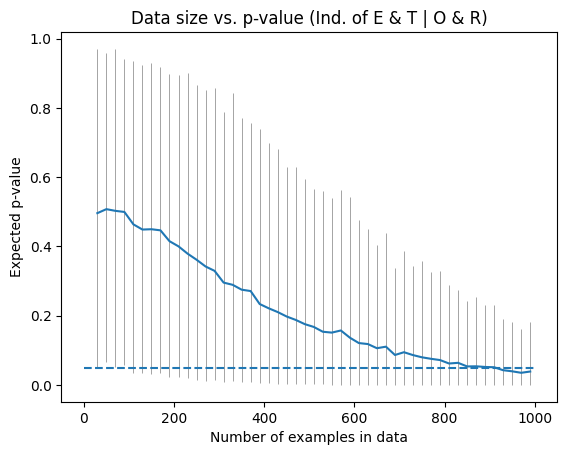

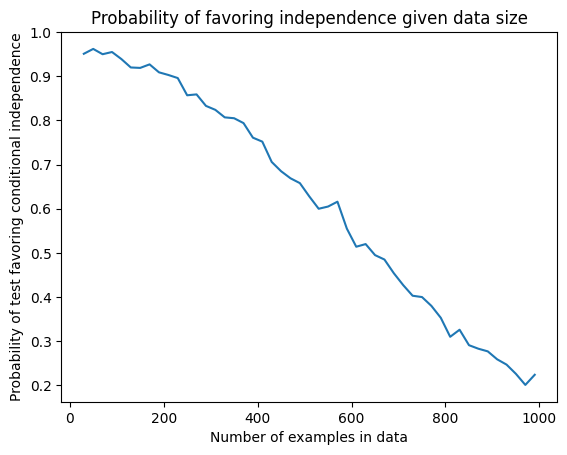

In [17]:
import numpy as np
import matplotlib.pyplot as plt

p_vals, lower_bars, higher_bars, probs_conclude_indep = result    #A
plt.title('Data size vs. p-value (Ind. of E & T | O & R)')    #B
plt.xlabel("Number of examples in data")    #B
plt.ylabel("Expected p-value")    #B
error_bars = np.array([lower_bars, higher_bars])    #B
plt.errorbar(    #B
    data_size,    #B
    p_vals,    #B
    yerr=error_bars,    #B
    ecolor="grey",    #B
    elinewidth=.5    #B
)    #B
plt.hlines(significance, 0, 1000, linestyles="dashed")    #B
plt.show()
plt.title('Probability of favoring independence given data size')    #C
plt.xlabel("Number of examples in data")    #C
plt.ylabel("Probability of test favoring conditional independence")    #C
plt.plot(data_size, probs_conclude_indep)    #C
#A Run the bootstrap analysis to get quantiles of p-values and probability of concluding in favor of independence.
#B Plot the data size vs p-value. At larger data sizes the expected p-value falls below a threshold.
#C Plot data size vs the probability of concluding in favor of independence given .05 significance.

The blue line in the above figure is the expected p-values at different data sizes, the grey lines are error bars showing a 90% bootstrap confidence interval. By the time we get to a data set of size 1000, the expected p-value is below the threshold, meaning the test favors the conclusion that E ⟂ T | O, R is false.

One might think that as the size of the data increases, the algorithm is detecting subtle dependencies between E and T that were undetectable with small data. Not so, for this transportation data is simulated in such a way that E ⟂ T | O, R is definitely true. So this is a case where more data leads us to rejecting independence because more data leads to more spurious correlation, i.e. patterns that aren't really there.

To drive the point home, the following figure shows how the probability of favoring the true hypothesis (E ⟂ T | O, R) decreases as the size of the data increases.

### Alternatives to canonical statistical tests for independence

There are alternatives to using traditional "parametric" (i.e., use chi-square, Normal distribution, or another canonical distribution to calculate a p-value) statistical hypothesis testing to test the causal Markov assumption. The library [PyWhy-Stats](https://github.com/py-why/pywhy-stats) has some more sophisticated approaches that can be applied towards causal inference. You can also simply try prediction; if (S ⟂ T | E), then a model that predicts S given E and T should not perform much better than an model that predicts S only given E.

Don't get too hung up on statistical rigor -- the goal is just to evaluate your causal DAG. You want to quickly <i>falsify</i> your causal DAG if it is a bad model and move on to finding a good one.